Setup Environment

In [1]:
from IPython.display import display
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import make_pipeline

Get Data

In [2]:
FILE_PATH = "data/segmentation_data.csv"
encoding = 'unicode_escape'
customer_info = pd.read_csv(FILE_PATH, encoding=encoding, parse_dates=['InvoiceDate'])

Dataset EDA

In [3]:
display(customer_info.head(10))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [4]:
customer_info[['Quantity', 'UnitPrice']].describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [5]:
# Check for non-null value counts and column Data Types
print(customer_info.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


In [6]:
# Convert Country column to category data type, this will help dummy variable encoding if necessary
customer_info['Country'] = customer_info.Country.astype('category')
print(customer_info.Country.dtype)

category


In [7]:
# Checking for missing values
print(customer_info.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [8]:
# Observe rows with missing values
display(customer_info[(customer_info.CustomerID.isnull()) | (customer_info.Description.isnull())])

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [9]:
# Handling missing values (dropping all rows with missing data)
customer_info.dropna(inplace=True)
print(customer_info.isnull().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [10]:
# Check for duplicated values (full row duplications, not duplicates specific to a certain CustomerID or Description)
customer_info.duplicated().sum()

5225

In [11]:
# Handling duplicated rows (drop all duplicated rows) and count remaining rows in dataframe
customer_info.drop_duplicates(inplace=True)
print(customer_info.shape)

(401604, 8)


In [12]:
# Find the transaction counterpart to a cancelled item, or if any portion of a transaction was returned
def find_trans_counterparts(bought, cancelled):
    """
    Find the transaction that was logged when a cancelled order was initally bought.
    """

    remove_trans = []
    add_cancel = []

    for row in cancelled.itertuples():
        index = row.Index

        # If the row is not a cancelled item, then continue
        if (row.Quantity > 0) | (row.Description == 'Discount'):
            continue
            
        # Compare row values for a match
        test_df = bought[
            (bought.CustomerID == row.CustomerID) &
            (bought.StockCode == row.StockCode) &
            (bought.UnitPrice == row.UnitPrice) &
            (bought.InvoiceDate < row.InvoiceDate) &
            (bought.Quantity > 0)
            ].copy()

        # If there are no returned transactions, then continue
        if len(test_df) == 0:
            continue

        # If there is only one returned transaction, append the index to remove_trans, unless the returned value is greater than the value that was bought
        elif (len(test_df) == 1) & (test_df.Quantity.values[0] >= (row.Quantity * -1)):
            remove_trans.append(index)
            add_cancel.append(test_df.index.values[0])

        elif (len(test_df) == 1) & (test_df.Quantity.values[0] < (row.Quantity * -1)):
            continue
        
        # If there are multiple transactions returned
        elif len(test_df) > 1:
            
            # Sort transactions starting with most recent transactions
            test_df.sort_values('InvoiceDate', ascending=False, inplace=True)
            quants = test_df.Quantity.values - (row.Quantity * -1)
            pos_quants = quants[quants >= 0]
            sorted_quants = sorted(pos_quants)

            # Continue if there are no transactions that are >= the cancelled quantity
            if len(pos_quants) < 1:
                continue

            elif len(pos_quants) >= 1:
                # Get first element that is >= 0 and find the index of the row that the transaction is located and append
                sorted_val = sorted_quants[0]
                val = pos_quants[pos_quants == sorted_val][0]
                i = np.where(quants==val)[0][0]
                remove_trans.append(index)
                add_cancel.append(test_df.index[i])
                
    return remove_trans, add_cancel

In [13]:
# Create df that includes all potential duplicate values (cancelled transactions)
dups_cancelled = customer_info[
    (customer_info.duplicated(subset=['CustomerID', 'StockCode', 'UnitPrice', 'Country', 'Description'], keep=False)) &
    (customer_info.Quantity < 0) &
    (customer_info.StockCode != "D")
]

# Create df that includes all potential duplicate values (initial transactions)
dups_bought = customer_info[
    (customer_info.duplicated(subset=['CustomerID', 'StockCode', 'UnitPrice', 'Country', 'Description'], keep=False)) &
    (customer_info.Quantity >= 0)
]

In [14]:
display(dups_cancelled)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
939,C536506,22960,JAM MAKING SET WITH JARS,-6,2010-12-01 12:38:00,4.25,17897.0,United Kingdom
1442,C536543,22355,CHARLOTTE BAG SUKI DESIGN,-2,2010-12-01 14:30:00,0.85,17841.0,United Kingdom
1973,C536548,22244,3 HOOK HANGER MAGIC GARDEN,-4,2010-12-01 14:33:00,1.95,12472.0,Germany
1974,C536548,22242,5 HOOK HANGER MAGIC TOADSTOOL,-5,2010-12-01 14:33:00,1.65,12472.0,Germany
...,...,...,...,...,...,...,...,...
540448,C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,2011-12-09 09:57:00,1.95,14397.0,United Kingdom
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [15]:
remove_trans, add_cancel = find_trans_counterparts(dups_bought, dups_cancelled)

In [16]:
def clean_customer_info(df, remove_list, add_list):
    """
    Drop all cancelled transactions that had an associated initial transaction, and create net unit and net profit col for cleaned_customer_info df.
    """

    cleaned_customer_info = df.copy(deep=True)

    # Adjust all Quantity column values to be greater than or equal to 0
    cleaned_customer_info['Quantity'] = cleaned_customer_info.Quantity.apply(lambda x: -x if x < 0 else x)

    # Create a new column that quantifies the amount of cancelled items pertaining to that bought transaction
    cleaned_customer_info['CancelledQuantity'] = cleaned_customer_info.apply(lambda x: x.Quantity if 'C' in x.InvoiceNo else 0, axis=1)

    index_list = [*zip(remove_list, add_list)]

    for r, a in index_list:
        quantity = cleaned_customer_info.loc[r, 'Quantity']
        cleaned_customer_info.loc[a, 'CancelledQuantity'] = quantity
        
    return cleaned_customer_info


In [17]:
cleaned_customer_info = clean_customer_info(customer_info, remove_trans, add_cancel)

In [18]:
# Create Net Quantity and Total Price columns for each transaction
cleaned_customer_info['NetQuantity'] = cleaned_customer_info.Quantity - cleaned_customer_info.CancelledQuantity
cleaned_customer_info['TotalPrice'] = cleaned_customer_info.NetQuantity * cleaned_customer_info.UnitPrice

# Drop any complex duplicates that are the returned transactions of the initial bought transactions
cleaned_customer_info.drop(remove_trans, axis=0, inplace=True)

In [19]:
# Check for any rows where the cancelled amount was greater than the ordered amount (should be 0 transactions, if correct)
print(len(cleaned_customer_info[(cleaned_customer_info.NetQuantity < 0) & (cleaned_customer_info.CancelledQuantity < 0)]))


0


In [20]:
display(cleaned_customer_info.sort_values('CancelledQuantity', ascending=True))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledQuantity,NetQuantity,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,6,15.30
367379,568894,23298,SPOTTY BUNTING,5,2011-09-29 13:04:00,4.95,17528.0,United Kingdom,0,5,24.75
367378,568894,22710,WRAP I LOVE LONDON,25,2011-09-29 13:04:00,0.42,17528.0,United Kingdom,0,25,10.50
367377,568894,22050,PINK PAISLEY ROSE GIFT WRAP,25,2011-09-29 13:04:00,0.42,17528.0,United Kingdom,0,25,10.50
367376,568894,21497,FANCY FONTS BIRTHDAY WRAP,25,2011-09-29 13:04:00,0.42,17528.0,United Kingdom,0,25,10.50
...,...,...,...,...,...,...,...,...,...,...,...
52710,540815,21175,GIN + TONIC DIET METAL SIGN,2000,2011-01-11 12:55:00,1.85,15749.0,United Kingdom,2000,0,0.00
52711,540815,21108,FAIRY CAKE FLANNEL ASSORTED COLOUR,3114,2011-01-11 12:55:00,2.10,15749.0,United Kingdom,3114,0,0.00
4287,C536757,84347,ROTATING SILVER ANGELS T-LIGHT HLDR,9360,2010-12-02 14:23:00,0.03,15838.0,United Kingdom,9360,0,0.00
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,74215,0,0.00


In [21]:
# Display unique values for all columns
display(cleaned_customer_info.nunique())

InvoiceNo            19540
StockCode             3684
Description           3896
Quantity               305
InvoiceDate          18160
UnitPrice              620
CustomerID            4372
Country                 37
CancelledQuantity      134
NetQuantity            317
TotalPrice            3104
dtype: int64

In [22]:
# Display top 10 countries that orders are placed in
print(cleaned_customer_info.Country.value_counts().head(10))

United Kingdom    350867
Germany             9093
France              8342
EIRE                7253
Spain               2485
Netherlands         2365
Belgium             2034
Switzerland         1844
Portugal            1457
Australia           1188
Name: Country, dtype: int64


In [23]:
# Which Countries are ordering the most items and what is the mean amount of items per orders
country_quantities = cleaned_customer_info.groupby('Country')[['NetQuantity']].agg(['sum', 'mean'])

display(country_quantities.sort_values(by=country_quantities.columns[0], ascending=False).head(10))

NetQuantity           
                       sum       mean
Country                              
United Kingdom     4022874  11.465524
Netherlands         200609  84.824101
EIRE                136484  18.817593
Germany             117622  12.935445
France              109888  13.172860
Australia            83657  70.418350
Sweden               35874  79.543237
Switzerland          29783  16.151302
Spain                26832  10.797586
Japan                25234  77.643077

In [24]:
# Which Countries are ordering the most expensive items and what is the average item price per order
country_prices = cleaned_customer_info.groupby('Country')[['UnitPrice']].agg(['sum', 'mean'])

display(country_prices.sort_values(by=country_prices.columns[0], ascending=False).head(10))

UnitPrice           
                        sum       mean
Country                               
United Kingdom  1137919.794   3.243166
France            41032.020   4.918727
EIRE              37146.900   5.121591
Germany           34402.260   3.783378
Singapore         19018.050  84.902009
Spain             12352.010   4.970628
Portugal          10234.510   7.024372
Belgium            7387.880   3.632193
Norway             6502.770   6.049088
Netherlands        6454.350   2.729112

In [25]:
# Are there customers that only ordered once?

## Remove cancelled transactions, under the assumption that you can't cancel anything you didn't buy
customer_trans_count = cleaned_customer_info[~cleaned_customer_info.InvoiceNo.str.contains('C')] \
    .groupby(by=['CustomerID'], as_index=False)['InvoiceDate'] \
    .count()

customer_trans_count.rename(columns={'InvoiceDate': 'Count'}, inplace=True)

display(customer_trans_count.sort_values(by='Count').head())
print(len(customer_trans_count[customer_trans_count.Count==1]))

,CustomerID,Count
0,12346.0,1
2443,15668.0,1
2434,15657.0,1
2363,15562.0,1
2334,15524.0,1


72


In [26]:
# Create column to signal cancelled transactions
cleaned_customer_info['Cancelled'] = cleaned_customer_info.CancelledQuantity.apply(lambda x: 1 if x > 0 else 0)

display(cleaned_customer_info.sort_values('Cancelled', ascending=False))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledQuantity,NetQuantity,TotalPrice,Cancelled
268167,560393,22635,CHILDS BREAKFAST SET DOLLY GIRL,1,2011-07-18 13:33:00,9.95,14808.0,United Kingdom,1,0,0.00,1
124795,546991,22948,METAL DECORATION NAUGHTY CHILDREN,6,2011-03-18 13:08:00,0.85,12748.0,United Kingdom,6,0,0.00,1
124809,546991,22991,GIRAFFE WOODEN RULER,6,2011-03-18 13:08:00,1.95,12748.0,United Kingdom,6,0,0.00,1
312639,564360,23294,SET OF 6 SNACK LOAF BAKING CASES,16,2011-08-24 16:13:00,0.83,12471.0,Germany,1,15,12.45,1
140713,548458,22690,DOORMAT HOME SWEET HOME BLUE,2,2011-03-31 11:53:00,7.95,15632.0,United Kingdom,2,0,0.00,1
...,...,...,...,...,...,...,...,...,...,...,...,...
194806,553671,21034,REX CASH+CARRY JUMBO SHOPPER,1,2011-05-18 12:37:00,0.95,13659.0,United Kingdom,0,1,0.95,0
194805,553671,15044C,PURPLE PAPER PARASOL,3,2011-05-18 12:37:00,2.95,13659.0,United Kingdom,0,3,8.85,0
194804,553671,22968,ROSE COTTAGE KEEPSAKE BOX,1,2011-05-18 12:37:00,9.95,13659.0,United Kingdom,0,1,9.95,0
194803,553671,22966,GINGERBREAD MAN COOKIE CUTTER,1,2011-05-18 12:37:00,1.25,13659.0,United Kingdom,0,1,1.25,0


In [27]:
# What percentage of transactions were cancelled in total?
perc_cancelled = cleaned_customer_info.Cancelled.mean()
print(f"{round(perc_cancelled*100, 2)}%")

2.17%


In [28]:
# What is the basket price (total price per transaction) per CustomerID?
trans_basket_price = cleaned_customer_info.groupby(["CustomerID", "InvoiceNo"], as_index=False)["TotalPrice"].sum()
trans_basket_price.rename(columns={"TotalPrice": "BasketPrice"}, inplace=True)
display(trans_basket_price)

,CustomerID,InvoiceNo,BasketPrice
0,12346.0,541431,0.00
1,12347.0,537626,711.79
2,12347.0,542237,475.39
3,12347.0,549222,636.25
4,12347.0,556201,382.52
...,...,...,...
19535,18283.0,579673,220.31
19536,18283.0,580872,208.00
19537,18287.0,554065,765.28
19538,18287.0,570715,1001.32


In [29]:
trans_basket_price.BasketPrice.describe()

count    19540.000000
mean       431.884378
std        940.847175
min          0.000000
25%        134.475000
50%        281.005000
75%        446.235000
max      38970.000000
Name: BasketPrice, dtype: float64

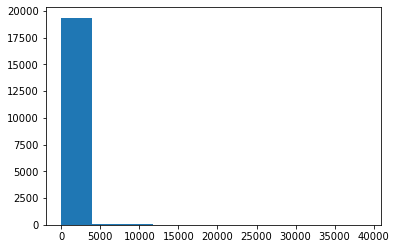

In [30]:
plt.hist(trans_basket_price.BasketPrice)
plt.show()

In [31]:
# What is total customer spend?
total_customer_spend = cleaned_customer_info.groupby('CustomerID', as_index=False)['TotalPrice'].agg("sum", "mean")
total_customer_spend.rename(columns={'TotalPrice': 'TotalSpend'}, inplace=True)
display(total_customer_spend)

,CustomerID,TotalSpend
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
...,...,...
4367,18280.0,180.60
4368,18281.0,80.82
4369,18282.0,176.60
4370,18283.0,2045.53


In [32]:
total_customer_spend.TotalSpend.describe()

count      4372.000000
mean       1930.242622
std        8352.636620
min           0.000000
25%         294.802500
50%         648.305000
75%        1616.537500
max      279801.020000
Name: TotalSpend, dtype: float64

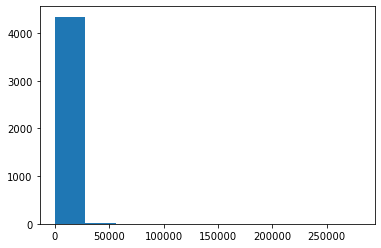

In [33]:
plt.hist(total_customer_spend.TotalSpend)
plt.show()

Customer Time Cohorts

In [34]:

# Convert datetime timestamps to dates (data includes 1 year or transcations 12.1.2010 - 12.9.2011)
cleaned_customer_info['InvoiceDate'] = cleaned_customer_info.InvoiceDate.apply(lambda x: dt.datetime(x.year, x.month, x.day))

# Create a cohort date that displays the first transaction date per customer at the transaction granularity
cohort_grouping = cleaned_customer_info.groupby('CustomerID')['InvoiceDate']
cleaned_customer_info['CohortDate'] = cohort_grouping.transform('min')

In [35]:
# Extract date parts from the date values
def get_date_int(df, col):
    years = df[col].dt.year
    months = df[col].dt.month
    days = df[col].dt.day
    return years, months, days

In [36]:
# Extract the date parts from InvoiceDate and CohortDate
trans_year, trans_month, trans_day = get_date_int(cleaned_customer_info, 'InvoiceDate')
cohort_year, cohort_month, cohort_day = get_date_int(cleaned_customer_info, 'CohortDate')

In [37]:
# Calculate the difference in years, months, and days
years_diff = trans_year - cohort_year
months_diff = trans_month - cohort_month
days_diff = trans_day - cohort_day

In [38]:
# Create Cohort Index column to evaluate the days difference from all previous values
cleaned_customer_info['CohortIndex'] = round(((years_diff * 365) + (months_diff * 30) + (days_diff * 1) ) / 30, 0) + 1

# Create Cohort Month column to 
cleaned_customer_info['CohortMonth'] = cleaned_customer_info['CohortDate'].apply(lambda x: dt.datetime(x.year, x.month, 1))

Create Retention and Spend tables (with Heatmaps)

In [39]:
# Create cohort retention table

## Count the number of unique values per CustomerID
cohort_data = cleaned_customer_info.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].apply(pd.Series.nunique).reset_index()

## Create pivot table to display cohort counts per month
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
display(cohort_counts)

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,948.0,238.0,351.0,289.0,371.0,329.0,355.0,311.0,335.0,341.0,360.0,428.0,404.0
2011-01-01,421.0,97.0,111.0,101.0,135.0,116.0,108.0,96.0,133.0,132.0,149.0,53.0,NaN
2011-02-01,380.0,66.0,85.0,94.0,97.0,87.0,100.0,100.0,100.0,110.0,31.0,NaN,NaN
2011-03-01,440.0,72.0,100.0,98.0,96.0,75.0,111.0,105.0,113.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,66.0,69.0,52.0,65.0,61.0,65.0,80.0,27.0,NaN,NaN,NaN,NaN
2011-05-01,279.0,49.0,47.0,49.0,52.0,65.0,77.0,31.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,235.0,44.0,41.0,55.0,64.0,80.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,191.0,40.0,33.0,42.0,51.0,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,167.0,30.0,45.0,43.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# Store first column of cohort_counts as cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Calculate retention rate based off the cohort_sizes
retention = cohort_counts.divide(cohort_sizes, 0)
display(retention)

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,1.0,0.251055,0.370253,0.304852,0.391350,0.347046,0.374473,0.328059,0.353376,0.359705,0.379747,0.451477,0.42616
2011-01-01,1.0,0.230404,0.263658,0.239905,0.320665,0.275534,0.256532,0.228029,0.315914,0.313539,0.353919,0.125891,NaN
2011-02-01,1.0,0.173684,0.223684,0.247368,0.255263,0.228947,0.263158,0.263158,0.263158,0.289474,0.081579,NaN,NaN
2011-03-01,1.0,0.163636,0.227273,0.222727,0.218182,0.170455,0.252273,0.238636,0.256818,0.088636,NaN,NaN,NaN
2011-04-01,1.0,0.220736,0.230769,0.173913,0.217391,0.204013,0.217391,0.267559,0.090301,NaN,NaN,NaN,NaN
2011-05-01,1.0,0.175627,0.168459,0.175627,0.186380,0.232975,0.275986,0.111111,NaN,NaN,NaN,NaN,NaN
2011-06-01,1.0,0.187234,0.174468,0.234043,0.272340,0.340426,0.093617,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,1.0,0.209424,0.172775,0.219895,0.267016,0.078534,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,1.0,0.179641,0.269461,0.257485,0.083832,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


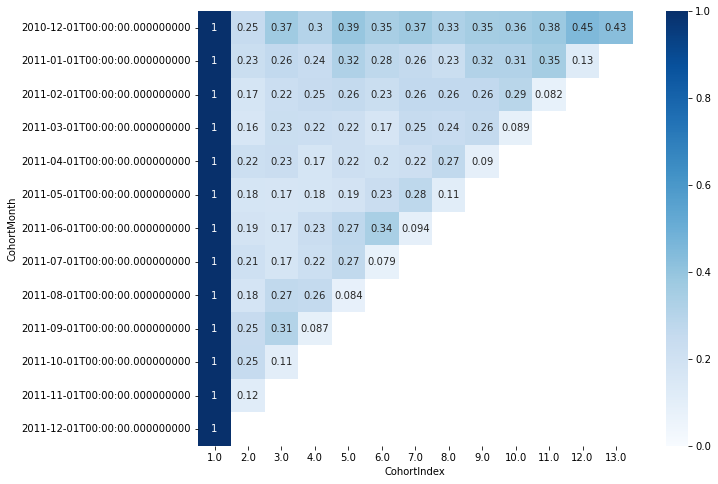

In [41]:
# Display Retention Heatmap for more comprehensive view of retention table
fig = plt.figure(figsize=(12,8))
sns.heatmap(
    data=retention,
    square=True,
    vmin=0,
    vmax=1,
    annot=True,
    cmap="Blues"
)

plt.show()

In [42]:
# Gather cohort spend data
cohort_spend_data = cleaned_customer_info.groupby(['CohortMonth', 'CohortIndex'], as_index=False)['UnitPrice'].mean()

# Create cohort spend table
avg_price = cohort_spend_data.pivot(index='CohortMonth', columns='CohortIndex', values='UnitPrice')
display(avg_price)

CohortIndex,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
CohortMonth,,,,,,,,,,,,,
2010-12-01,3.180823,3.273646,3.178937,3.003510,3.495936,5.232534,3.147430,2.904436,3.764854,2.849065,3.327982,2.923894,2.830918
2011-01-01,3.316802,4.260040,5.163599,3.158448,3.264177,2.903586,2.970075,2.631044,2.733788,5.587239,2.895065,2.498770,NaN
2011-02-01,3.524912,3.198282,4.445405,3.155007,3.012090,2.744740,2.843695,3.268522,2.838171,2.865025,3.250924,NaN,NaN
2011-03-01,3.393189,3.720221,3.236324,3.384629,3.182805,2.783554,2.712363,2.775597,2.669110,2.671746,NaN,NaN,NaN
2011-04-01,3.404721,3.345068,3.653343,2.653550,2.995856,2.885038,2.721173,2.858422,2.760580,NaN,NaN,NaN,NaN
2011-05-01,4.251805,3.014328,2.743032,2.898216,2.598106,2.510035,2.630747,2.513296,NaN,NaN,NaN,NaN,NaN
2011-06-01,10.674733,3.179699,2.897112,3.113211,2.594201,2.962406,2.393813,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,4.416435,2.862348,2.666642,2.728538,2.400011,2.375324,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,3.122013,5.744723,6.131375,6.967527,3.368894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


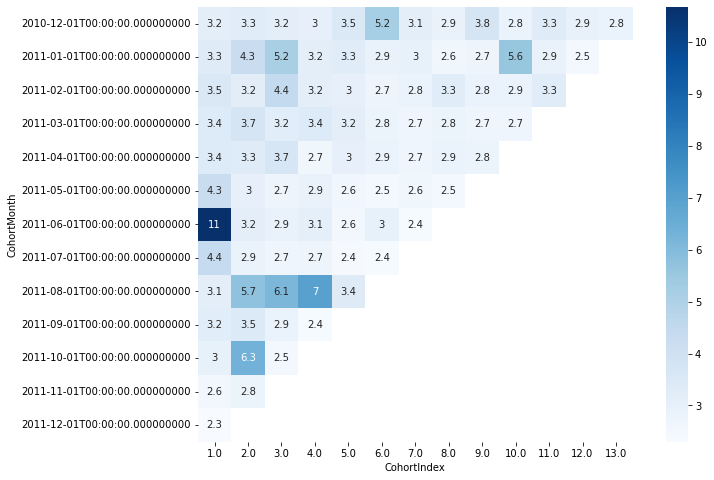

In [43]:
# Display Cohort Avg. Spend Heatmap for more comprehensive view
fig = plt.figure(figsize=(12,8))
sns.heatmap(
    data=avg_price,
    square=True,
    annot=True,
    cmap="Blues"
)
plt.show()

Recency, Frequency, Monetary (RFM) Segmentation

In [44]:
# Create snapshot date to analyze customer data relative to dates data was collected
from datetime import timedelta
snapshot_date = cleaned_customer_info.InvoiceDate.max() + timedelta(days=1)

# Create customer trends (recency based off of the snapshot_date --> max InvoiceDate + 1 day )
customer_trends = cleaned_customer_info.groupby(['CustomerID']) \
    .agg(
        {
            'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
		    'InvoiceNo': 'count',
            'UnitPrice': 'sum'
        }
    )

customer_trends.rename(
    columns={
        'InvoiceDate': 'Recency',
        'InvoiceNo': 'Frequency',
        'UnitPrice': 'MonetaryValue'
    },
    inplace=True
)

display(customer_trends)

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346.0,326,1,1.04
12347.0,3,182,481.21
12348.0,76,31,178.71
12349.0,19,73,605.10
12350.0,311,17,65.30
...,...,...,...
18280.0,278,10,47.65
18281.0,181,7,39.36
18282.0,8,12,62.39


In [45]:
# Build RFM segments

## Create group labels that rank each RFM value (based on lowest value "1" as the "best" score someone can get)
r_labels = range(3,0,-1)
f_labels = range(1,4)
m_labels = range(1,4)

## Create groups for RFM values
r_groups = pd.qcut(customer_trends.Recency, q=3, labels=r_labels)
f_groups = pd.qcut(customer_trends.Frequency, q=3, labels=f_labels)
m_groups = pd.qcut(customer_trends.MonetaryValue, q=3, labels=m_labels)

## Create new "R", "F", "M" columns
customer_trends = customer_trends.assign(R=r_groups, F=f_groups, M=m_groups)

## Create RFM_Score column
customer_trends['RFM_Score'] = customer_trends[['R', 'F', 'M']].sum(axis=1)

display(customer_trends.RFM_Score.value_counts().sort_index())

3    668
4    579
5    707
6    593
7    538
8    542
9    745
Name: RFM_Score, dtype: int64

In [46]:
# Define rfm_tier function
def rfm_tier(df):
    """
    Split RFM_Score values into three distinct groups of customers... "Top", "Middle", "Bottom"
    """

    if df.RFM_Score >= 8:
        return "Top"
    elif df.RFM_Score >= 5:
        return "Middle"
    else:
        return "Bottom"

In [47]:
# Segment each customer into each "Tier"
customer_trends['RFM_Tier'] = customer_trends.apply(rfm_tier, axis=1)

## Delete CustomerID due to invalid transaction information
customer_trends.drop(13256, inplace=True)

display(customer_trends)

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Tier
CustomerID,,,,,,,,
12346.0,326,1,1.04,1,1,1,3,Bottom
12347.0,3,182,481.21,3,3,3,9,Top
12348.0,76,31,178.71,2,2,2,6,Middle
12349.0,19,73,605.10,3,3,3,9,Top
12350.0,311,17,65.30,1,1,1,3,Bottom
...,...,...,...,...,...,...,...,...
18280.0,278,10,47.65,1,1,1,3,Bottom
18281.0,181,7,39.36,1,1,1,3,Bottom
18282.0,8,12,62.39,3,1,1,5,Middle


In [48]:
# Analyze RFM Tiers by average values
rfm_tier_agg = customer_trends.groupby('RFM_Tier') \
    .agg(
        {
            'Recency': 'mean',
            'Frequency': 'mean',
            'MonetaryValue': 'mean',
            'RFM_Tier': 'count'
        }
    ) \
    .round(1) \
    .rename(columns={'RFM_Tier': 'Count'})

display(rfm_tier_agg)

,Recency,Frequency,MonetaryValue,Count
RFM_Tier,,,,
Bottom,180.7,12.3,39.3,1247
Middle,84.9,46.7,179.3,1837
Top,22.0,228.0,755.0,1287


Preprocessing for k-Means Clustering

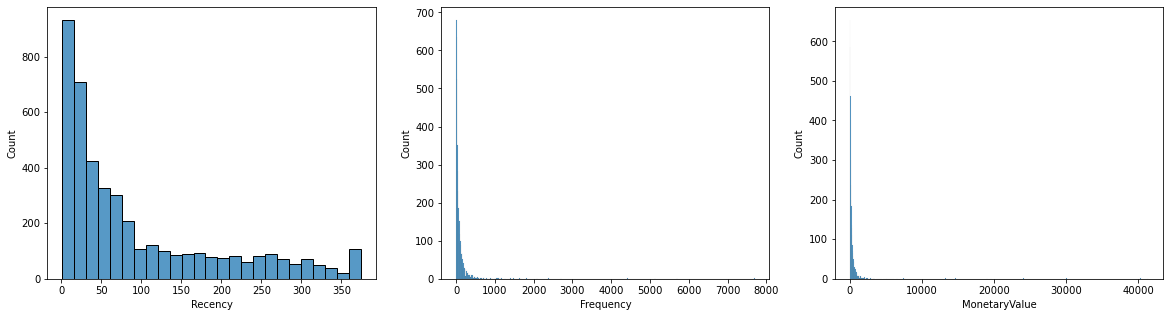

In [49]:
# Plot distribution of RFM variables
fig = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

## Plot Recency distribution
plt.subplot(1,3,1)
sns.histplot(customer_trends.Recency)

## Plot Frequency distribution
plt.subplot(1,3,2)
sns.histplot(customer_trends.Frequency)

## Plot MonetaryValue distribution
plt.subplot(1,3,3)
sns.histplot(customer_trends.MonetaryValue)

plt.show()

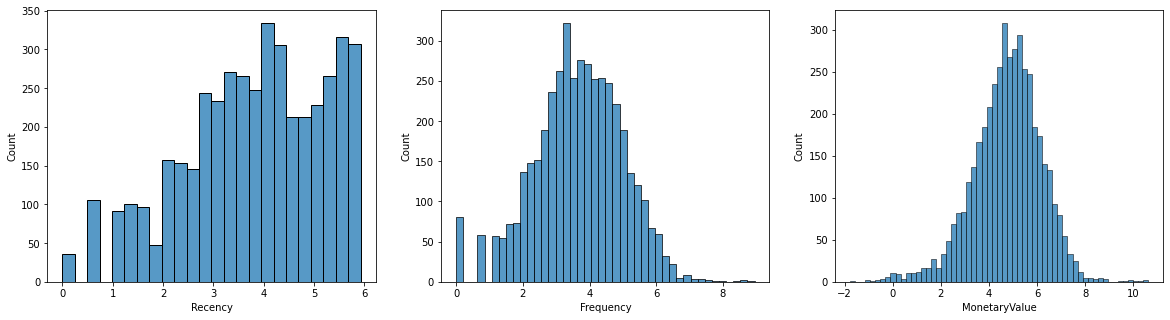

In [50]:
# Plot log-transformed distribution of RFM variables (log-transformed values will be used to avoid distribution skewness)
fig = plt.subplots(nrows=1, ncols=3, figsize=(20,5))

## Plot Recency distribution
plt.subplot(1,3,1)
sns.histplot(np.log(customer_trends.Recency))

## Plot Frequency distribution
plt.subplot(1,3,2)
sns.histplot(np.log(customer_trends.Frequency))

## Plot MonetaryValue distribution
plt.subplot(1,3,3)
sns.histplot(np.log(customer_trends.MonetaryValue))

plt.show()

In [61]:
# Preprocess (prepare) the customer_trends values

## Instantiate PowerTransformer function to fix skewness
powerT = PowerTransformer(method='yeo-johnson')

## Scale values to align values to similar scales
scaler = StandardScaler()

## Create and use pipeline to transform data into new df ready for clustering
pipeline = make_pipeline(powerT, scaler)
customer_trends_norm = pipeline.fit_transform(customer_trends[['Recency', 'Frequency', 'MonetaryValue']])
customer_trends_norm = pd.DataFrame(data=customer_trends_norm, index=customer_trends.index, columns=customer_trends.columns[:3])

display(customer_trends_norm.describe())

,Recency,Frequency,MonetaryValue
count,4.371000e+03,4.371000e+03,4.371000e+03
mean,-2.024360e-17,-1.408416e-17,6.200396e-17
std,1.000114e+00,1.000114e+00,1.000114e+00
min,-2.092765e+00,-2.381216e+00,-3.114765e+00
25%,-7.452700e-01,-6.592034e-01,-6.345041e-01
50%,-8.501443e-03,-6.609453e-03,7.328766e-03
75%,8.436004e-01,6.967773e-01,6.454281e-01
max,1.736816e+00,4.240179e+00,4.927676e+00


Implement k-Means Clustering on Processed Dataset

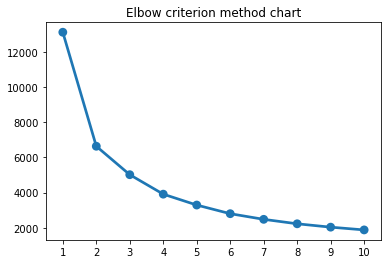

In [62]:
# Determine the correct amount of clusters for customer_trends values

## Create empty sse (squared-sum error) dictionary
sse = {}

## Fit KMeans algorithm on k values between 1 and 11
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=333)
    kmeans.fit(customer_trends_norm)
    sse[k] = kmeans.inertia_

## Add the title to the elbow chart
plt.title('Elbow criterion method chart')

## Create and display a scatter plot to analyze elbow chart
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [101]:
# Assign and interpret segments

## Create k-Means instance and fit to normalized customer data
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(customer_trends_norm)

## Assign segments to each customer based on 4 customer segments
customer_trends_norm_3 = customer_trends_norm.assign(Segment=kmeans.labels_)

## Analyze the customer segment counts
display(customer_trends_norm_3.Segment.value_counts())

0    1224
3    1147
2    1103
1     897
Name: Segment, dtype: int64

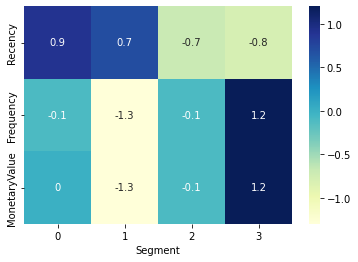

In [102]:
# Group by the segment label and calculate average column values
kmeans4_averages = customer_trends_norm_3.groupby(['Segment']).mean().round(1)

# Create a heatmap on the average column values per each segment
sns.heatmap(kmeans4_averages.T, cmap='YlGnBu', annot=True)

# Display the chart
plt.show()

In [105]:
# Create Snake plot data table in correct format
customer_trends_melt = pd.melt(
    customer_trends_norm_3.reset_index(),
    id_vars=['CustomerID', 'Segment'],
    value_vars=['Recency', 'Frequency', 'MonetaryValue'],
    var_name='Metric',
    value_name='Value'
)
display(customer_trends_melt)

,CustomerID,Segment,Metric,Value
0,12346.0,1,Recency,1.601428
1,12347.0,3,Recency,-1.717506
2,12348.0,0,Recency,0.304852
3,12349.0,3,Recency,-0.709933
4,12350.0,0,Recency,1.555543
...,...,...,...,...
13108,18280.0,1,MonetaryValue,-0.682999
13109,18281.0,1,MonetaryValue,-0.815014
13110,18282.0,2,MonetaryValue,-0.494029
13111,18283.0,3,MonetaryValue,1.750528


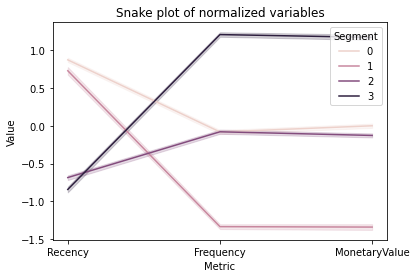

In [106]:
# Create Snake Plot
plt.title('Snake plot of normalized variables')
plt.xlabel('Metric')
plt.ylabel('Value')

## Plot a line for each value of the cluster variable
sns.lineplot(data=customer_trends_melt, x='Metric', y='Value', hue='Segment')

## Display Snake plot
plt.show()

In [114]:
# Compare RFM_Tiers with Segments from kMeans model
group_compare = customer_trends_norm_3.merge(customer_trends['RFM_Tier'], on='CustomerID').reset_index()
group_compare = group_compare.groupby(['Segment', 'RFM_Tier'])['CustomerID'].count().reset_index()

display(pd.pivot_table(data=group_compare, index='RFM_Tier', columns='Segment', values='CustomerID'))

Segment,0,1,2,3
RFM_Tier,,,,
Bottom,357.0,833.0,57.0,NaN
Middle,832.0,64.0,903.0,38.0
Top,35.0,NaN,143.0,1109.0
